In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
import pandas as pd
from torch import optim
import re
import json
import cv2
# import albumentations
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss

In [4]:

import numpy as np
import torch
import pandas as pd
import random
import string

In [10]:
j = json.load(open('../../data/bounding_boxed/annotations.json'))

In [12]:
SZ = 360

In [13]:
class CustomDataset(Dataset):
    def __init__(self, j, aug=None):
        self.j = j
        if aug is not None: aug = get_aug(aug)
        self.aug = aug
    
    def __getitem__(self, idx):
        item = j2anno(self.j[idx])
        if self.aug: item = self.aug(**item)
        im, bbox = item['image'], np.array(item['bboxes'][0])
        im, bbox = self.normalize_im(im), self.normalize_bbox(bbox)
        
        return im.transpose(2,0,1).astype(np.float32), bbox.astype(np.float32)
    
    def __len__(self):
        return len(self.j)
    
    def normalize_im(self, ary):
        return ((ary / 255 - imagenet_stats[0]) / imagenet_stats[1])
    
    def normalize_bbox(self, bbox):
        return bbox / SZ

In [16]:
src = (ImageList.from_folder(path='../../data/train').split_by_rand_pct(0.0).label_from_folder())

In [17]:
src

LabelLists;

Train: LabelList (82417 items)
x: ImageList
Image (3, 372, 500),Image (3, 600, 800),Image (3, 500, 375),Image (3, 293, 500),Image (3, 400, 500)
y: CategoryList
class-390,class-390,class-390,class-390,class-390
Path: ../../data/train;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: ../../data/train;

Test: None

In [18]:
tfms = get_transforms(do_flip=True,flip_vert=False,max_rotate=10.0,max_zoom=1.1,max_lighting=0.2,max_warp=0.2,p_affine=0.75,p_lighting=0.75)

In [19]:
data = (src.transform(tfms, size=360, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=32).normalize(imagenet_stats))

In [20]:
data

ImageDataBunch;

Train: LabelList (82417 items)
x: ImageList
Image (3, 360, 360),Image (3, 360, 360),Image (3, 360, 360),Image (3, 360, 360),Image (3, 360, 360)
y: CategoryList
class-390,class-390,class-390,class-390,class-390
Path: ../../data/train;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: ../../data/train;

Test: None

In [21]:
class SnakeDetector(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch)
        self.head = create_head(num_features_model(self.cnn) * 2, 4)
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return x.sigmoid_()

In [22]:
learn = Learner(data, SnakeDetector(arch=models.resnet50), loss_func=L1Loss())

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/angus/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [04:19<00:00, 395kB/s] 


In [23]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

Learner(data=ImageDataBunch;

Train: LabelList (82417 items)
x: ImageList
Image (3, 360, 360),Image (3, 360, 360),Image (3, 360, 360),Image (3, 360, 360),Image (3, 360, 360)
y: CategoryList
class-390,class-390,class-390,class-390,class-390
Path: ../../data/train;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: ../../data/train;

Test: None, model=SnakeDetector(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

In [28]:
state_dict = torch.load('/home/angus/Models/snakes/snake-detection-model.pth')

In [29]:
learn.model.load_state_dict(state_dict['model'])

<All keys matched successfully>

In [30]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (82417 items)
x: ImageList
Image (3, 360, 360),Image (3, 360, 360),Image (3, 360, 360),Image (3, 360, 360),Image (3, 360, 360)
y: CategoryList
class-390,class-390,class-390,class-390,class-390
Path: ../../data/train;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: ../../data/train;

Test: None, model=SnakeDetector(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

In [24]:
import os

In [25]:
if not os.path.exists('temp_test'):
    os.makedirs('temp_test')

In [35]:
src_new = (ImageList.from_folder(path='../../data/bounding_boxed/train-object-detect').split_by_rand_pct(0.0).label_from_folder())

In [36]:
str_name = str(src_new.items[0])

In [37]:
str_name

'../../data/bounding_boxed/train-object-detect/0c07c7e8b2aad95313a3aa34738681b7.jpg'

In [34]:
learn.predict(open_image(str_name))

(Category class-140, tensor(2), tensor([0.1448, 0.2784, 0.7998, 0.7378]))

In [38]:
plt

<module 'matplotlib.pyplot' from '/home/angus/anaconda3/envs/snakes/lib/python3.6/site-packages/matplotlib/pyplot.py'>

../../data/bounding_boxed/train-object-detect/0c07c7e8b2aad95313a3aa34738681b7.jpg
../../data/bounding_boxed/train-object-detect/0c07c7e8b2aad95313a3aa34738681b7.jpg


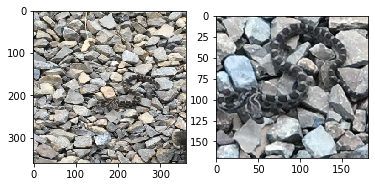

../../data/bounding_boxed/train-object-detect/0e4f4f4b8ff7dfa0f335c7a3899f2d80.jpg
../../data/bounding_boxed/train-object-detect/0e4f4f4b8ff7dfa0f335c7a3899f2d80.jpg


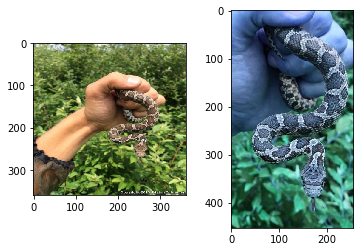

../../data/bounding_boxed/train-object-detect/0f3a4984e87eb4477e84a83f28ee352a.jpg
../../data/bounding_boxed/train-object-detect/0f3a4984e87eb4477e84a83f28ee352a.jpg


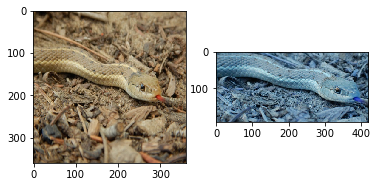

../../data/bounding_boxed/train-object-detect/0a5e7ad0e4e8d7c212e5176b06714802.jpg
../../data/bounding_boxed/train-object-detect/0a5e7ad0e4e8d7c212e5176b06714802.jpg


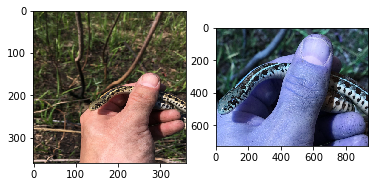

../../data/bounding_boxed/train-object-detect/1a445edbfa8a27be9b2ee43939381771.jpg
../../data/bounding_boxed/train-object-detect/1a445edbfa8a27be9b2ee43939381771.jpg


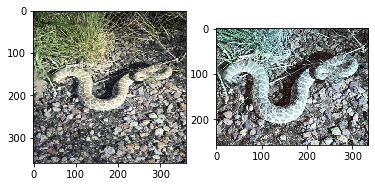

../../data/bounding_boxed/train-object-detect/0d59d4082765f4615d7ce083ede732ee.jpg
../../data/bounding_boxed/train-object-detect/0d59d4082765f4615d7ce083ede732ee.jpg


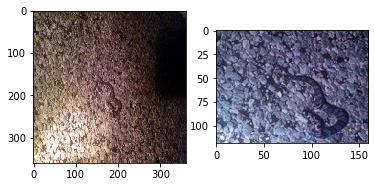

../../data/bounding_boxed/train-object-detect/0af3b4649678a13065b58d5deb0b3be2.jpg
../../data/bounding_boxed/train-object-detect/0af3b4649678a13065b58d5deb0b3be2.jpg


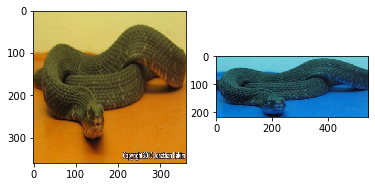

../../data/bounding_boxed/train-object-detect/0b4dca42a9ea0a88785017f67fcdebf0.jpg
../../data/bounding_boxed/train-object-detect/0b4dca42a9ea0a88785017f67fcdebf0.jpg


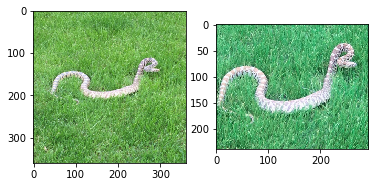

../../data/bounding_boxed/train-object-detect/01f8ec33285249d72621f1c6a6aa6979.jpg
../../data/bounding_boxed/train-object-detect/01f8ec33285249d72621f1c6a6aa6979.jpg


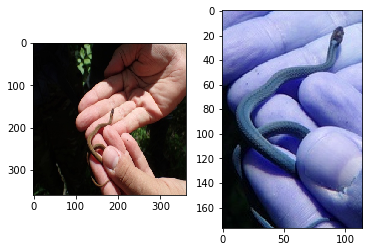

../../data/bounding_boxed/train-object-detect/0b9f915704768853810c0b38c2ce98d9.jpg
../../data/bounding_boxed/train-object-detect/0b9f915704768853810c0b38c2ce98d9.jpg


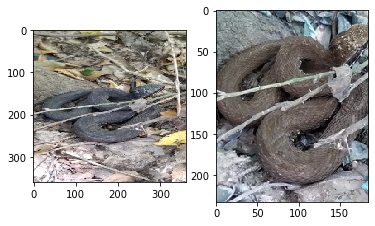

../../data/bounding_boxed/train-object-detect/0a37e6094fa4fd13e230d36479a55565.jpg
../../data/bounding_boxed/train-object-detect/0a37e6094fa4fd13e230d36479a55565.jpg


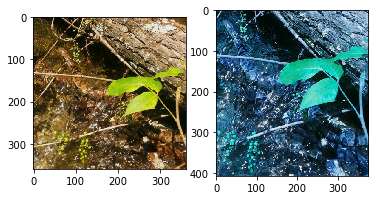

In [39]:
i=0
for filename in src_new.items:
    im = cv2.imread(f"{filename}", cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (360,360), interpolation = cv2.INTER_AREA)
    im_height, im_width, _ = im.shape
    print(str(filename))
    orig_im = cv2.imread(f"{filename}", cv2.IMREAD_COLOR)
    orig_im_height, orig_im_width, _ = orig_im.shape
    to_pred = open_image(filename)
    _,_,bbox=learn.predict(to_pred)
    im_original = cv2.imread(f"{filename}", cv2.IMREAD_COLOR)
    im_original = cv2.cvtColor(im_original, cv2.COLOR_BGR2RGB)
    im_original.shape
    im_original_width = im_original.shape[1]
    im_original_height = im_original.shape[0]
    bbox_new = bbox
    bbox_new[0] = bbox_new[0]*im_original_width 
    bbox_new[2]= bbox_new[2]*im_original_width
    bbox_new[1] = bbox_new[1]*im_original_height
    bbox_new[3] = bbox_new[3]*im_original_height
    x_min, y_min, x_max, y_max = map(int, bbox_new)
    #cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    im_original = im_original[y_min:y_max,x_min:x_max]
    im_original = cv2.cvtColor(im_original,cv2.COLOR_BGR2RGB)
    filename_str = str(filename)
    to_save = filename_str.replace('round1_test\\round1','temp_test')
    print(to_save)
    cv2.imwrite(to_save,im_original)
    plt.subplot(121)
    plt.imshow(im)
    plt.subplot(122)
    plt.imshow(im_original)
    plt.show()
    if i==10:
        break
    i+=1